In [1]:
from os import path as osp
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
COLOR_BAD = 'tab:red'
COLOR_OK = 'tab:blue'
COLOR_ACC = 'tab:green'

In [24]:
def error_analysis(trans_rot, err_fname, err_cutoff, err_target, err_accura, root, plot_bar=False):

    if trans_rot == 'trans':
        unit_str = 'm'
    elif trans_rot == 'rot':
        unit_str = 'deg'
    else:
        print(f'Unexpected trans_rot string {trans_rot}')
        return

    err_all = np.load(osp.join(root, err_fname))
    cam_xs = np.load(osp.join(root, 'camera_x_coords.npy'))
    cam_as = np.load(osp.join(root, 'camera_x_angles.npy'))
    sigmas = np.load(osp.join(root, 'noise_sigmas.npy')) * 1000 # mm
    
    cam_xs = np.linspace(0.3,0.8,5)
    cam_as = np.linspace(-115,-130,5)
    n_pos = len(cam_xs)
    n_ang = len(cam_as)
    
    n_noise_levels = len(sigmas)
    n_noise_repeat = err_all.shape[-1]

    sigma_ids = np.linspace(1, n_noise_levels, n_noise_levels)

    err_bad = np.sum(err_all > err_target, -1) / n_noise_repeat
    err_ok = np.sum((err_all > err_accura) & (err_all <= err_target), -1) / n_noise_repeat
    err_acc = np.sum(err_all <= err_accura, -1) / n_noise_repeat
    err_all = np.clip(err_all, 0, err_cutoff)

    def format_fn(tick_val, tick_pos):
        if int(tick_val) in sigma_ids:
            return sigmas[int(tick_val)-1]
        else:
            return ''

    fig, axx = plt.subplots(n_ang, n_pos, figsize=(10, 8), sharex=True, sharey=True)
    pos_i = 0
    ang_i = 0
    sigma_i = 0

    for pos_i in range(n_pos):
        for ang_i in range(n_ang):

            axx[pos_i, ang_i].scatter(
                np.linspace(1, n_noise_levels, n_noise_levels).reshape((-1, 1)).repeat(n_noise_repeat, 1).flatten(),
                err_all[pos_i, ang_i, :, :].flatten(),
                alpha=0.5, color='k', s=20)
            axx[pos_i, ang_i].plot([0, n_noise_levels+1], [err_accura, err_accura], '--', color=COLOR_ACC, label=f'{err_accura} {unit_str}')
            axx[pos_i, ang_i].plot([0, n_noise_levels+1], [err_target, err_target], '--', color=COLOR_OK, label=f'{err_target} {unit_str}')
            axx[pos_i, ang_i].plot([0, n_noise_levels+1], [err_cutoff, err_cutoff], '--', color=COLOR_BAD, label=f'{err_cutoff} {unit_str}')
            axx[pos_i, ang_i].set_xlim([0.5, n_noise_levels+0.5])

            if pos_i == n_pos-1 and ang_i == 2:
                axx[pos_i, ang_i].set_xlabel('Noise std. (mm)')

            if ang_i == 0 and pos_i == 2:
                axx[pos_i, ang_i].set_ylabel(f'Error. ({unit_str})')

            axx[pos_i, ang_i].xaxis.set_major_formatter(format_fn)
            axx[pos_i, ang_i].xaxis.set_major_locator(MaxNLocator(integer=True))

            # summarize rating of registration
            if plot_bar:
                ax_r = axx[pos_i, ang_i].twinx()
                ax_r.bar(sigma_ids, err_acc[pos_i, ang_i], color=COLOR_ACC, alpha=0.2,
                                    label=f'Accurate [0, {err_accura}] {unit_str}')
                ax_r.bar(sigma_ids, err_ok[pos_i, ang_i], bottom=err_acc[pos_i, ang_i], color=COLOR_OK, alpha=0.2,
                                    label=f'Feasible [{err_accura}, {err_target}] {unit_str}')
                ax_r.bar(sigma_ids, err_bad[pos_i, ang_i], bottom=err_acc[pos_i, ang_i]+err_ok[pos_i, ang_i], color=COLOR_BAD, alpha=0.2,
                                    label=f'Bad [{err_cutoff}, inf] {unit_str}')

                if ang_i == n_ang-1 and pos_i == 2:
                    ax_r.set_ylabel('Rating (%)')
                    ax_r.set_yticks([0,1])

                if ang_i != n_ang-1:
                    ax_r.set_yticklabels([])
                    ax_r.set_yticks([])
                
                if pos_i == 1 and ang_i == n_ang-1:
                    ax_r.legend(loc='upper left', bbox_to_anchor=[1.2, 1])

            if pos_i == 0 and ang_i == n_ang-1:
                axx[pos_i, ang_i].legend(loc='upper left', bbox_to_anchor=[1.2, 1])

    col_headers = [f'Cam X rot = {ang:.1f} deg' for ang in cam_as]
    row_headers = [f'Cam X pos = {pos:.2f} m' for pos in cam_xs]

    for ax, col in zip(axx[0], col_headers):
        ax.annotate(col, xy=(0.5, 1), xytext=(0, 5),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline', rotation=10)

    for ax, row in zip(axx[:,0], row_headers):
        ax.annotate(row, xy=(0, 0.5), xytext=(-4, 0),
                    xycoords='axes fraction', textcoords='offset fontsize',
                    size='large', ha='right', va='center')

    # plt.tight_layout()
    
    fig.suptitle(f'{trans_rot} error analysis')

    fig.savefig(f'env_calib_{trans_rot}_err.png', bbox_inches = 'tight', facecolor='white')
    


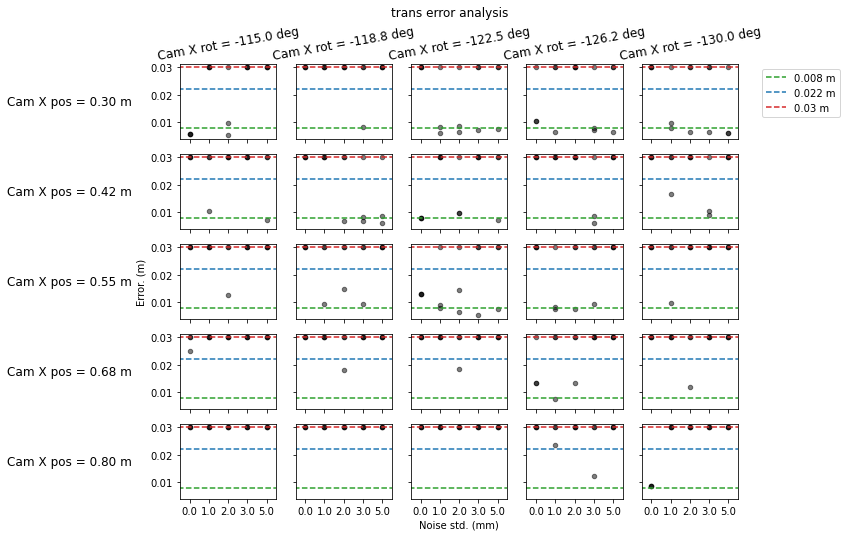

In [25]:
# trans_err_cutoff = 0.02
# trans_err_target = 0.015
# trans_err_accura = 0.005
trans_err_cutoff = 0.03
trans_err_target = 0.022
trans_err_accura = 0.008
root = '/home/zhongqi/Documents/workspace/MASCEI/Auto_calibration/data/conveyor_test'
# root = '/home/zhongqi/Documents/workspace/MASCEI/Auto_calibration/data/bagger_test'
trans_err_fname = 'trans_err_all.npy'
rot_err_fname = 'rot_err_all.npy'

error_analysis('trans', trans_err_fname, trans_err_cutoff, trans_err_target, trans_err_accura, root)

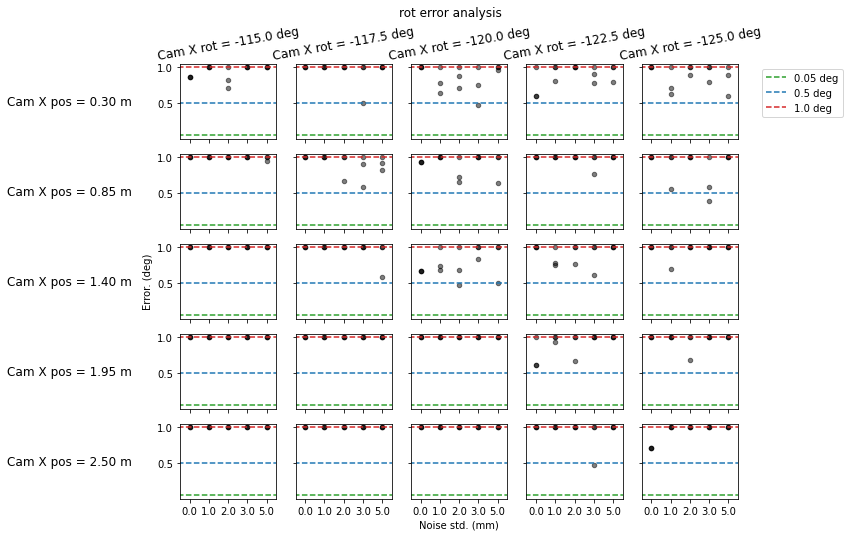

In [16]:
rot_err_cutoff = 1.0
rot_err_target = 0.5
rot_err_accura = 0.05

error_analysis('rot', rot_err_fname, rot_err_cutoff, rot_err_target, rot_err_accura, root)